<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Self_Attention_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Self-Attention Generative Adversarial Networks**

논문 링크: https://arxiv.org/abs/1805.08318

지금까지 convolutional GAN이 생성한 sample들을 보면 multi-class dataset을 학습시 몇몇의 class에 대해 어려움을 겪는 것을 알 수 있다. 예를 들어 강아지를 생성한다고 하면 강아지의 털에 대한 질감(texture)은 잘 표현하지만 강아지의 발을 명확하게 분리되게 표현하는데에 실패하는 것이다.

이러한 이유는 **지금까지 GAN이 convolution에 강하게 의존해왔기 때문**이다. 하지만 Convnet의 특성상 local receptive field를 가지고 있기 때문에 이미지에서 멀리 떨어져있는 부분에 대한 dependency를 알기 위해선 꽤 많은 convolution layer를 거쳐야 한다.

즉, 작은 모델들은 long range dependency를 표현할 수 없으며, 그렇다해서 convolution kernel을 키울라고 하니 연산량이 많아지고 local conv 구조를 사용함으로써 얻는 통계적인 이점이 모호해진다.

따라서 본 논문에서는 논문의 이름에서 나와있듯이 long-term dependency를 학습할 수 있는 장점을 가진 **self-attention을 GAN과 결합**하여 이를 해결했다.

(기존에 gan과 attention을 결합한 논문이 있긴 했는데, 바로 text-to-image 모델 중 하나인 AttnGAN이다. 하지만, AttnGAN에서는 attention을 단순 input sequence에서 word embedding에 사용했기 때문에 internal model states에서의 self-attention은 아니였다.)

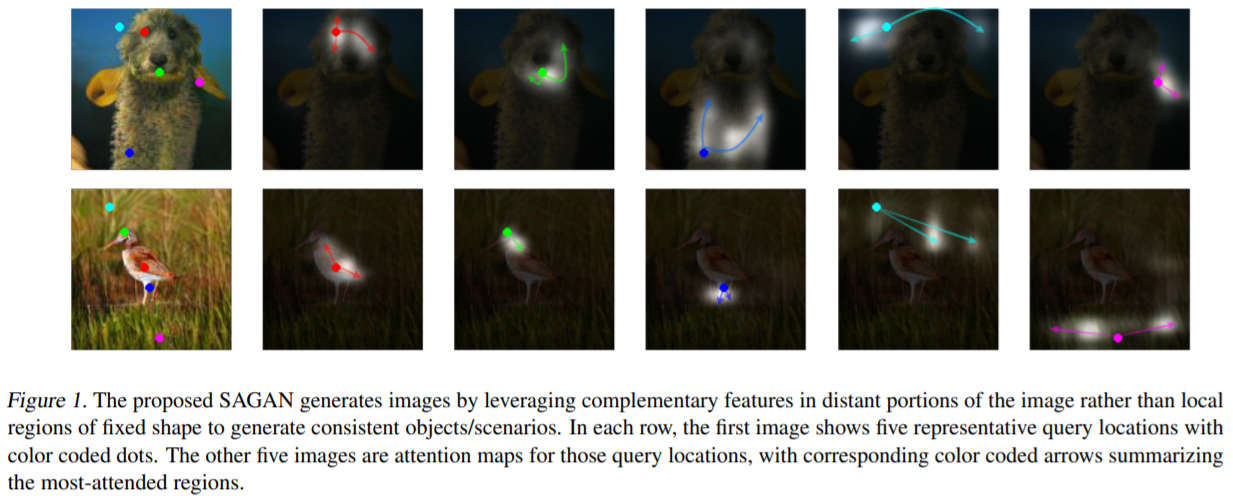

위의 그림 Figure 1은 각 query에 대한 attention map으로 query에 대해 가장 집중해서 보는 지역을 보여준다.

## **SAGAN 구조**

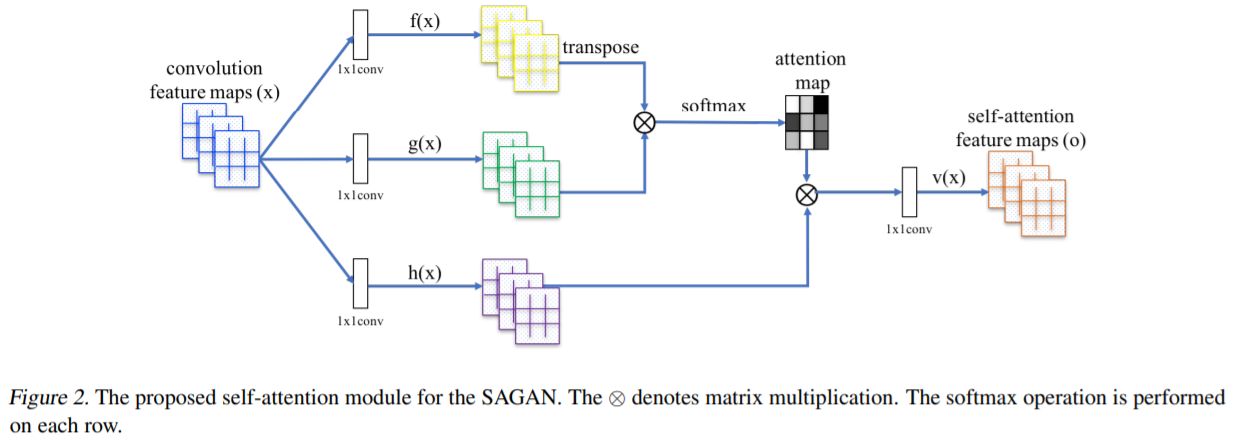

위의 그림 Figure 2를 보면 앞서 언급하였던 self-attention을 어떻게 적용하였는지 자세히 알 수 있다.

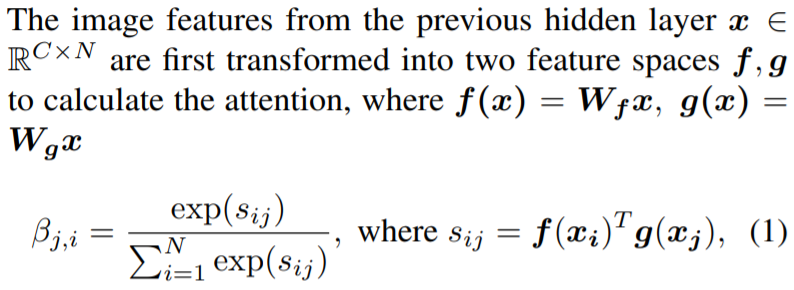

위의 문장부터 천천히 내려가보겠다.

위의 식에서 x는 이전 hidden layer로부터의 image feature이다.(위의 그림 Figure 2에서 맨 왼쪽 파란색에 해당한다.)

x ∈ R^(CxN)이 의미하는 것은 image가 3차원의 tensor인데(width x height x channel) 즉, x가 원래 H x W x C의 tensor지만 이를 H x W로 이루어진 feature를 하나의 row(N = H x W)로 만들어준 것이다. 그러면 총 C개의 row가 생기므로 C x N꼴이 되는 것이다.

이때 x는 attention을 계산하기 위해이때 x는 attention을 계산하기 위해 두개의 feature space인 f와 g로 변환이 된다. (위의 그림 Figure 2에서 각각 노란색과 초록색에 해당한다.)

그리고 **s_ij는 f(x)의 i번째 column vector와 g(x)의 j번째 column vector를 내적한 값으로써 두 벡터의 similarity**를 나타낸다. 즉, 모든 i, j번째의 feature location에 대한 관계를 구하는 것이다.

**따라서 위의 식의 B_ij는 model이 j번째 region 합성(sysnthesizing)할 때 i번째 region에 대한 집중하는 정도**를 나타낸다. 그리고 마지막으로 softmax 값으로 확률값이 나오게 된다. 이때 C는 channel의 수이며 N은 이전 hidden layer에 대한 feature들의 feature location 수이다. 이렇게해서 N x N Attention map이 생성이 된다.

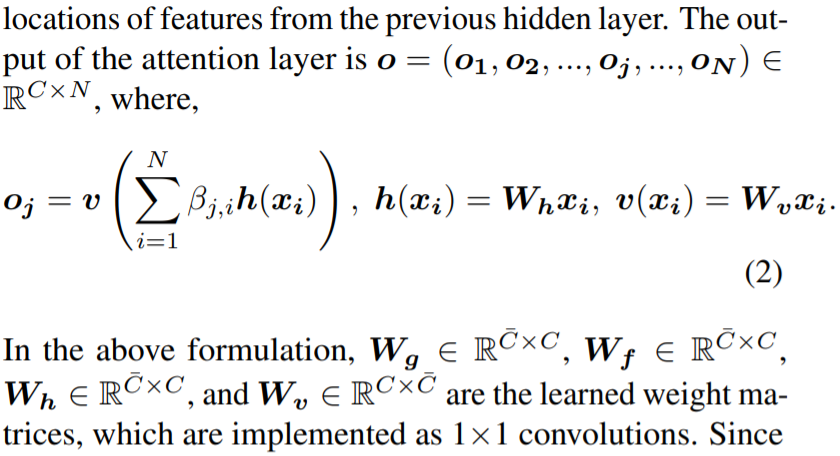

위의 문장은 최종적인 attention layer의 output이 어떻게 되는지 적혀있다.

먼저 **h(x_i)는 i번째 region에 대한 정보를 담은 벡터**이며, **B_ij는 위에서 말했듯이 j번째 region과 i번째 region의 상관정도**이다. 즉, 위의 식에서 이 둘을 곱한다는 것은 어느부분이 부각이 되어야 하는지를 attention 정도를 곱해주어 그 중요도를 높이거나 낮추는 작업을 하는 것이다.

따라서 **o_j는 j번째 region이 전체 region과 얼마만큼의 관계가 있는지에 대한 정도**라고 생각하면 된다. 또한 마지막에 W_v를 곱해주는데 이는 원래 input과의 channel 수를 맞추기 위해서이다.

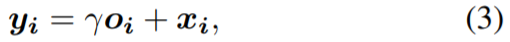

그리고 이제 최종적으로 위의 식과 같이 원래의 input feature과 더해주면 최종적인 output이 나온다. (이때, γ는 학습이 가능한 scalar값이며, 초기값은 0으로 지정이 된다. γ를 대입한 이유는 network가 초기에는 local nighborhood에서 단서를 얻도록하며 점점 학습이 진행될수록 non-local 단서들에 중점을 맞추기 위해서이다.)

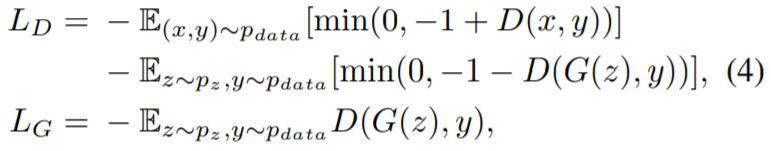

SAGAN에서는 generator와 discriminator 모두 위에서 설명한 attention module을 사용하게 되며, 위의 식과 같이 generator와 discriminator는 adversarial loss의 hinge version을 최소화함으로써 학습이 진행이 된다.

(추가적으로 SNGAN에서 제안된 **spectral normalization**를 각 층에 적용시켰으며, 정규화된 discriminator에서의 느린 학습을 해결하기 위해 **(TTUR)two-timescale update rule**을 사용했다.)

# **Experiments**

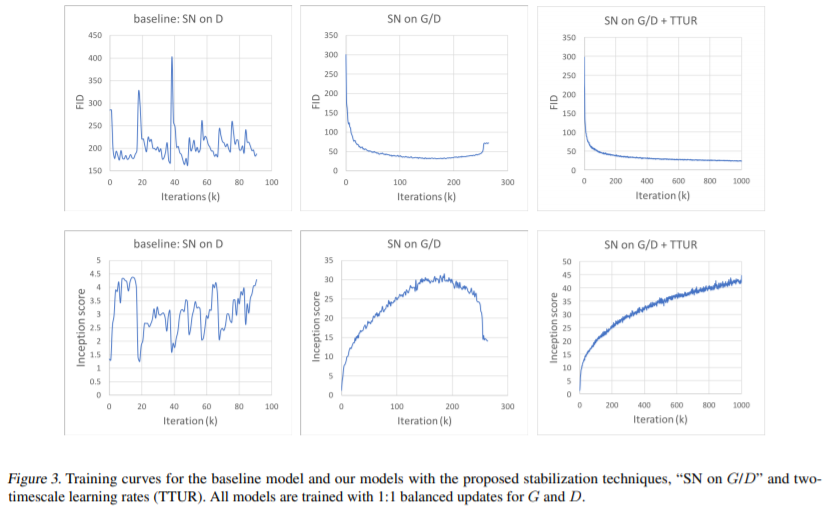

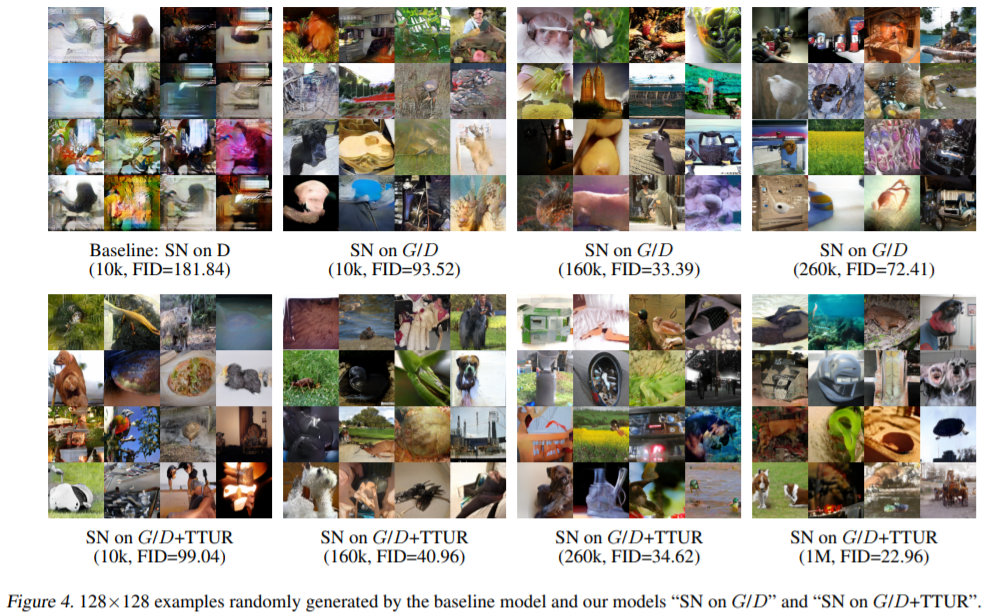

기본적으로 모든 SAGAN model들은 128 x 128 size의 image를 생성하도록 설계가 되었다. 위의 그림들 Figure 3과 Figure 4는 SN과 TTUR에 따른 metric의 결과와 image의 결과를 보여준다. SN on G/D + TTUR이 제일 좋은 성능을 보여준다.

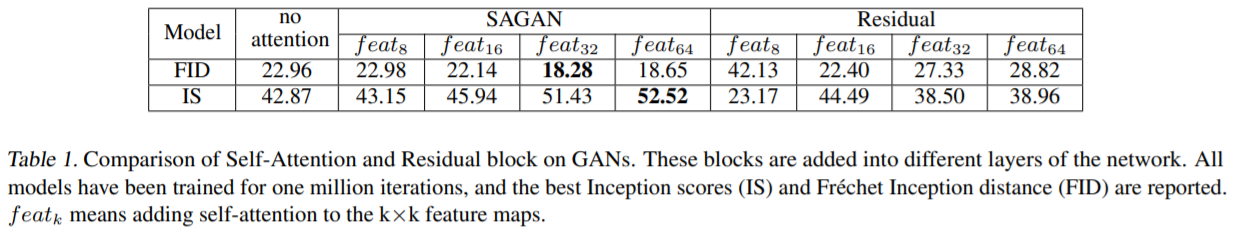

위의 표 Table 1에서는 GAN에 self-attention을 적용한 결과와 residual block을 적용한 결과를 각각 보여준다. FID와 IS 두 지표에서 모두 SAGAN이 더 우수하다는 것을 알 수 있다.

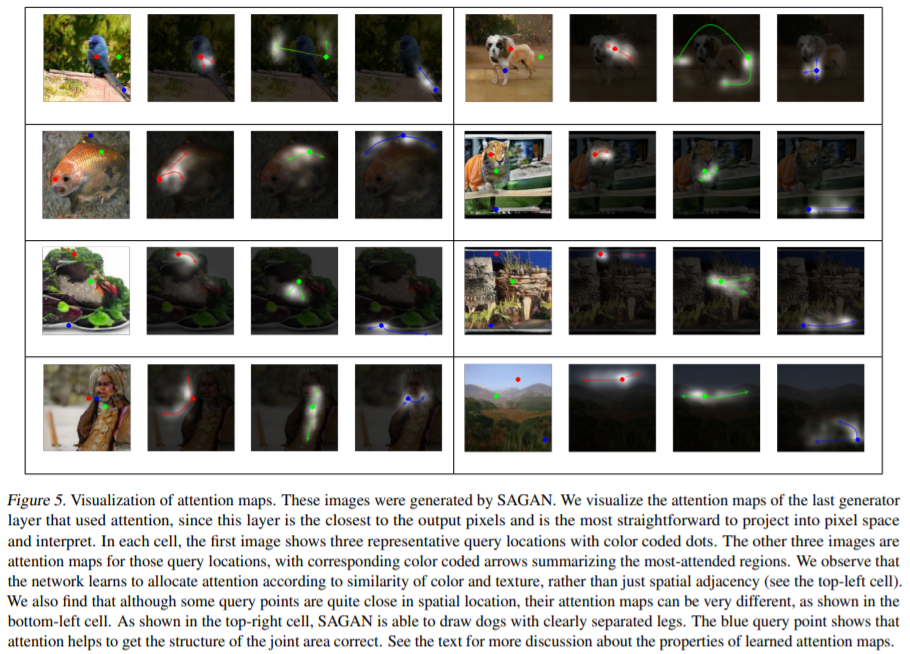

위의 그림 Figure 5는 attention map을 시각화한 것이다.

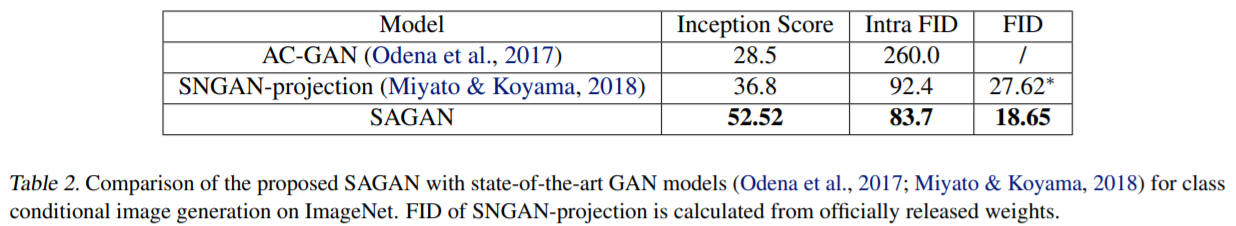

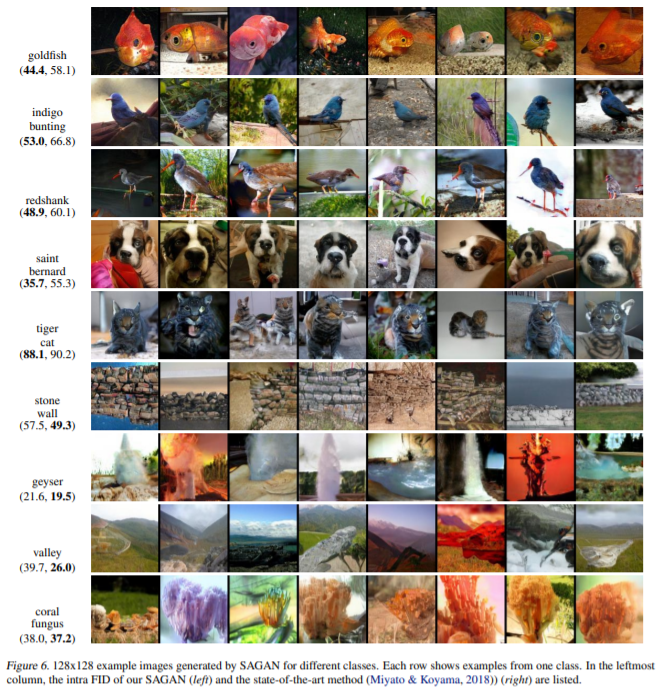

위의 표 Table 2와 그림 Figure 6에서는 각각 SOTA model과의 결과를 지표와 이미지로 비교한 것이다.